# Phonon workflow

This is the phonon workflow that is based on the finite displacement approach as implemented in [Phonopy](https://phonopy.github.io/phonopy/).

If you want to read more about Phonopy, please read Togo's paper: [https://doi.org/10.7566/JPSJ.92.012001](https://doi.org/10.7566/JPSJ.92.012001)

Let's install atomate2 first:

In [1]:
 %%capture
 !pip install git+https://github.com/materialsproject/atomate2.git@main[strict]

## Let's start with the workflow

We now simply load the force field phonon workflow. It uses CHGNet as a universal ML potential by default.

In [2]:
from atomate2.forcefields.flows.phonons import PhononMaker
from pymatgen.core.structure import Structure

struct = Structure(
        lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
        species=["Si", "Si"],
        coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
    )
phonon_flow = PhononMaker(min_length=15.0, store_force_constants=False).make(structure=struct)

## Let's have a look at the computing jobs
The phonon run will first perform a bulk relaxation, then the displacements are generated and run.
As we currently don't have a way to compute BORN charges with such potentials, a non-analytical term correction is not performed here.


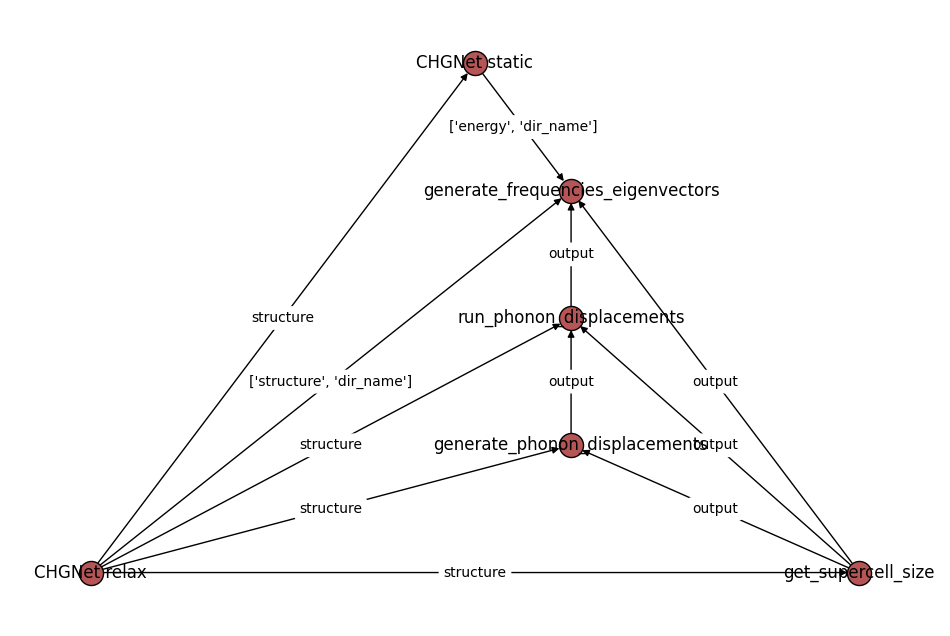

In [3]:
phonon_flow.draw_graph().show()

## Let's execute the workflow


In [4]:
%%capture
from jobflow import run_locally

run_locally(phonon_flow, create_folders=True)

## Let's have a look at the outputs

We query our database for the relevant outputs (here DOS and band structure)


In [5]:
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import PhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    {"name": "generate_frequencies_eigenvectors"},
    properties=[
        "output.phonon_dos",
        "output.phonon_bandstructure",
    ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
)

We can then easily plot the results:


<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

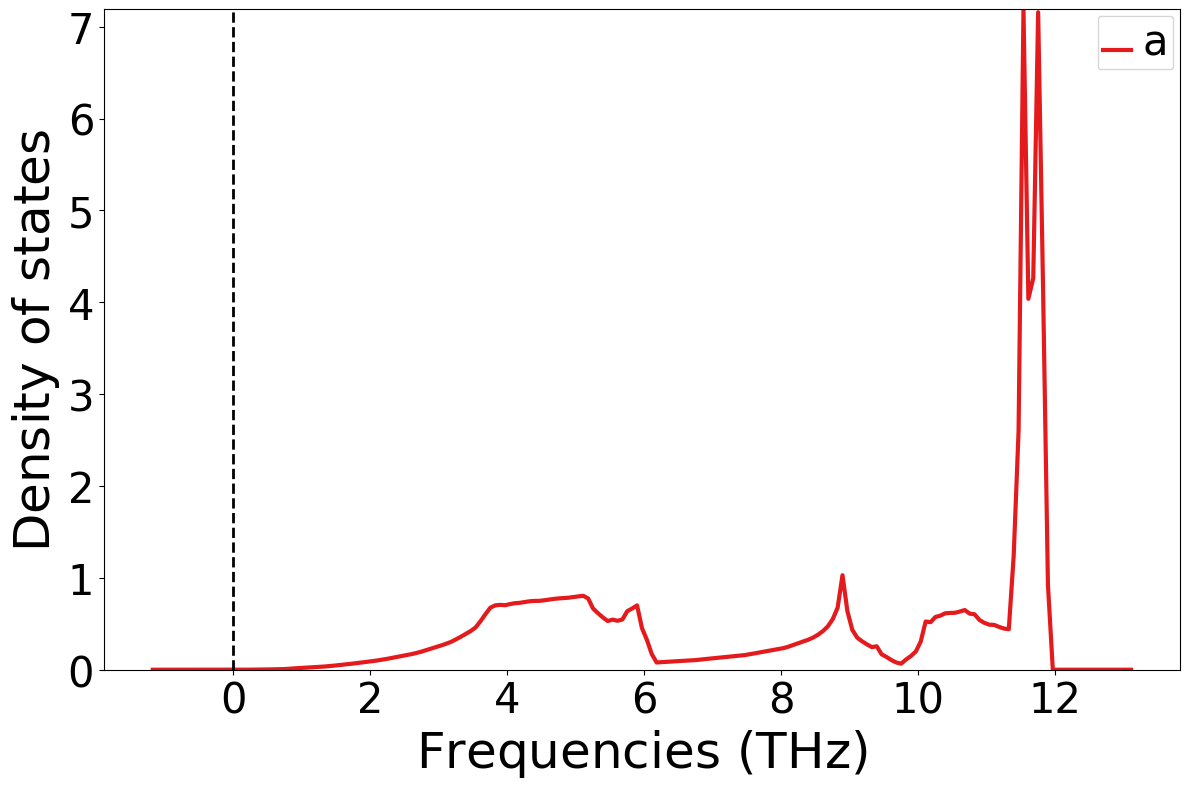

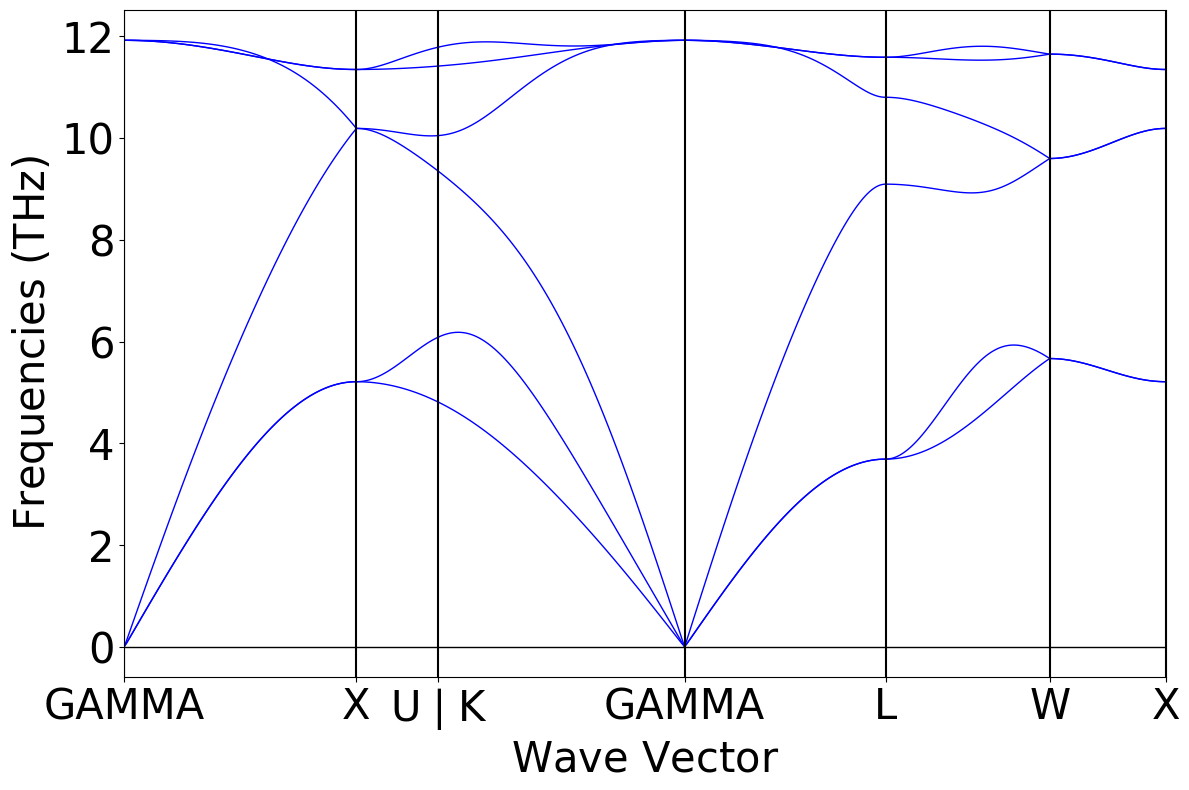

In [6]:
ph_bs = PhononBandStructureSymmLine.from_dict(result['output']['phonon_bandstructure']) # get pymatgen bandstructure object
ph_dos = PhononDos.from_dict(result['output']['phonon_dos']) # get pymatgen phonon dos object

# initialize dos plotter and visualize dos plot
dos_plot = PhononDosPlotter()
dos_plot.add_dos(label='a', dos=ph_dos)
dos_plot.get_plot()

# initialize Phonon bandstructure plotter and visualize band structure plot
bs_plot = PhononBSPlotter(bs=ph_bs)
bs_plot.get_plot()


## Change the force field

Are you now interested in how M3GNet performs?


In [7]:
from jobflow import SETTINGS
from jobflow import run_locally
from pymatgen.core.structure import Structure

from atomate2.forcefields.flows.phonons import PhononMaker
from atomate2.forcefields.jobs import M3GNetRelaxMaker, M3GNetStaticMaker

from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import PhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter

struct = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
)
phonon_flow = PhononMaker(min_length=15.0, store_force_constants=False,
                          bulk_relax_maker=M3GNetRelaxMaker(relax_kwargs={"fmax": 0.00001}),
                          phonon_displacement_maker=M3GNetStaticMaker(),
                          static_energy_maker=None).make(structure=struct)

In [8]:
%%capture
run_locally(phonon_flow, create_folders=True, store=SETTINGS.JOB_STORE)

We can again visualize the results:


<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

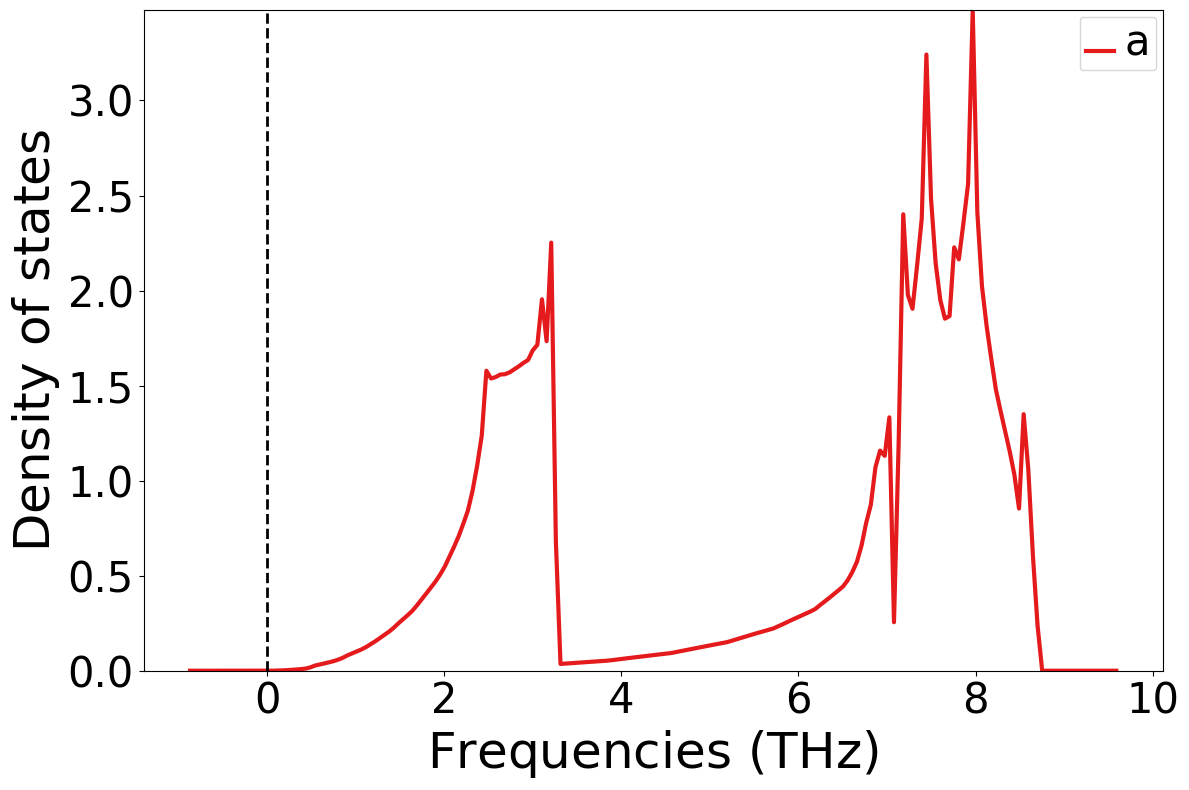

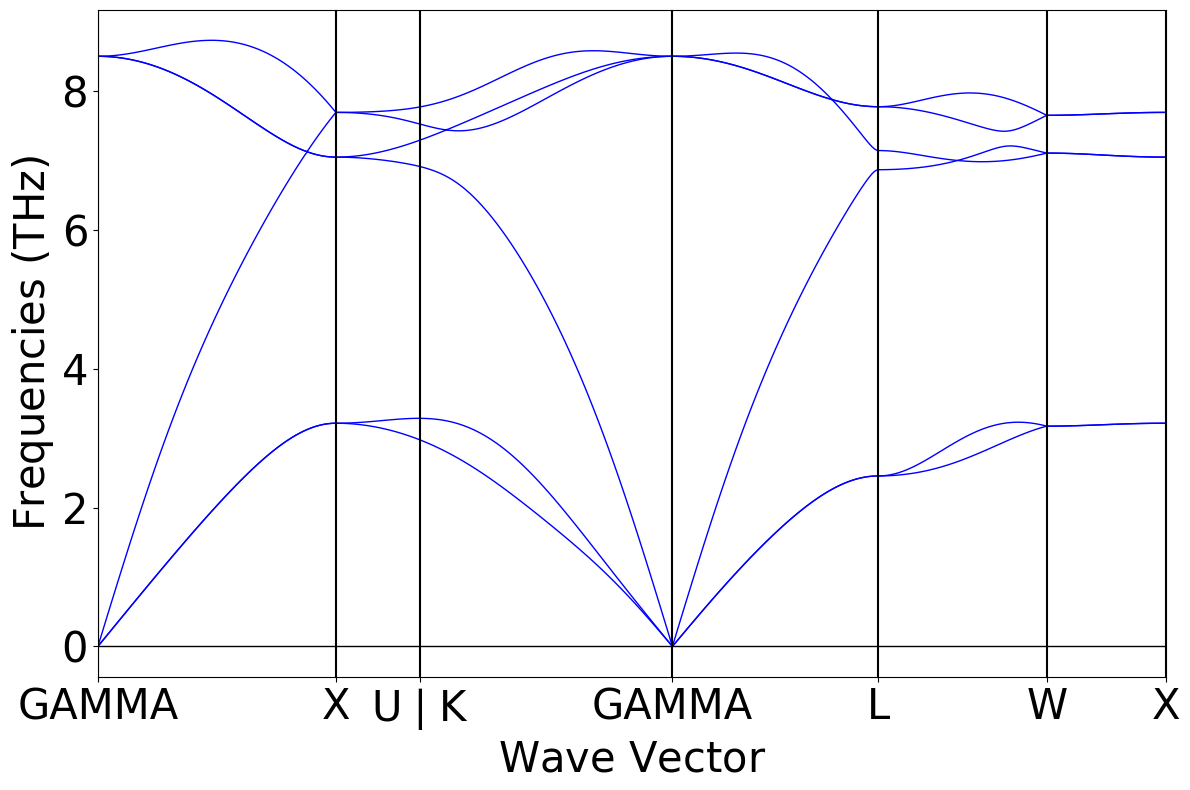

In [9]:
store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    {"name": "generate_frequencies_eigenvectors"},
    properties=[
        "output.phonon_dos",
        "output.phonon_bandstructure",
    ],
    load=True,
    sort={"completed_at": -1} # to get the latest computation
)

ph_bs = PhononBandStructureSymmLine.from_dict(
    result['output']['phonon_bandstructure'])  # get pymatgen bandstructure object
ph_dos = PhononDos.from_dict(result['output']['phonon_dos'])  # get pymatgen phonon dos object

# initialize dos plotter and visualize dos plot
dos_plot = PhononDosPlotter()
dos_plot.add_dos(label='a', dos=ph_dos)
dos_plot.get_plot()

# initialize Phonon bandstructure plotter and visualize band structure plot
bs_plot = PhononBSPlotter(bs=ph_bs)
bs_plot.get_plot()


## Note on levels of theory

While the results for Si look very promising, you might need to carefully check for other materials.

We also have GAP interface, that you might want to try.

## DFT?

The same workflow can also be executed with DFT. Currently, a VASP interface exits. More interfaces are under development.

